## Re-examine SF_Uncert metric in DDF regarding season length (Analysis)

In [8]:
# development code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os, sys

In [10]:
# add the path the scripts
sys.path.insert(0, "../scripts/")

In [11]:
# import rubin_sim python modules
import rubin_sim.maf.db as db
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.plots as plots
import rubin_sim.maf.metricBundles as metricBundles
import rubin_sim.maf as maf
from rubin_sim.maf.utils import m52snr

# footprint utils
from rubin_sim.scheduler.utils import footprints

# import convenience functions
from opsimUtils import *

# import custom stacker/metrics from script
from agnstructure import *

# print version
import rubin_sim

rubin_sim.__version__

'0.10.1.dev64+gc32f68b'

### 1. Pull rolling opsims to evaluate 

In [12]:
families = maf.archive.get_family_descriptions()
family_list = families.index.values

# pull roll runs
fam = ["ddf season length"]
baseline_run = families.loc["ddf season length", "reference"]
ddf_runs = np.concatenate([[baseline_run], families.explode("run").loc[fam, "run"]])
ddf_runs

array(['baseline_v2.1_10yrs', 'ddf_season_length_slf0.10_v2.1_10yrs',
       'ddf_season_length_slf0.15_v2.1_10yrs',
       'ddf_season_length_slf0.20_v2.1_10yrs',
       'ddf_season_length_slf0.25_v2.1_10yrs',
       'ddf_season_length_slf0.30_v2.1_10yrs',
       'ddf_season_length_slf0.35_v2.1_10yrs'], dtype=object)

### 2. LogTGaps

In [13]:
dbDir = rubin_sim.data.get_data_dir()
outDir = "/home/jovyan/mount/ResearchData/MAFOutput/ddf_tgap/ResultsDb"
metricDataPath = "/home/jovyan/mount/ResearchData/MAFOutput/ddf_tgap/MetricData"

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))

if not os.path.exists(os.path.abspath(metricDataPath)):
    os.makedirs(os.path.abspath(metricDataPath))

In [14]:
# create dict for storing dbs
opSimDbs, resultDbs = connect_dbs(dbDir, outDir, dbRuns=ddf_runs)

In [93]:
ddfFields = ['COSMOS', 'XMM-LSS', 'ELAISS1', 'ECDFS', 'EDFS']
agn_m5 = {"u": 22.89, "g": 23.94, "r": 23.5, "i": 22.93, "z": 22.28, "y": 21.5}

In [15]:
# retrieve metricBundles for each opsim run and store them in a dictionary
bundleDicts = {}

for runName in resultDbs:
    bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, \
                                              metricDataPath)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slic

#### 2.1 10 bins

Text(0.5, 1.0, 'COSMOS_g; 10 bins')

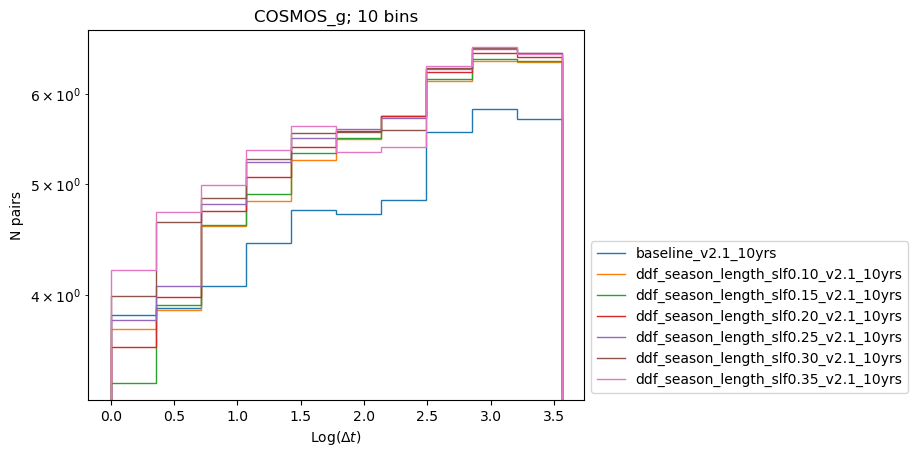

In [112]:
# plot COSMOS in g band
bin10 = np.logspace(0, np.log10(3650), 10+1)
for run in bundleDicts:
    bDict = bundleDicts[run]
    key = [metricKey for metricKey in bDict.keys() 
           if metricKey[1] == 'logTGap_COSMOS_g_10'][0]
    metric = bDict[key]
    mask = metric.metricValues.mask
    data = metric.metricValues.data[~mask]
    nobs_md = np.median(np.vstack(data), axis=0)
    
    plt.stairs(np.log10(nobs_md), np.log10(bin10), label=run)
    
plt.xlabel('Log($\Delta t$)')
plt.yscale('log')
plt.legend(loc=3, bbox_to_anchor=(1.,0.))
plt.ylabel('N pairs')
plt.title('COSMOS_g; 10 bins')

#### 2.2 20 bins

Text(0.5, 1.0, 'COSMOS_g; 20 bins')

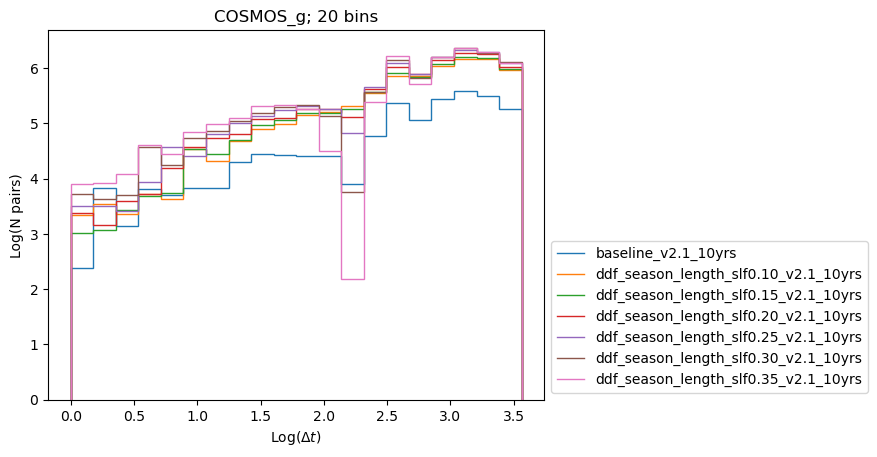

In [ ]:
# plot COSMOS in g band
bin20 = np.logspace(0, np.log10(3650), 20+1)
for run in bundleDicts:
    bDict = bundleDicts[run]
    key = [metricKey for metricKey in bDict.keys() 
           if metricKey[1] == 'logTGap_XMM-LSS_g_20'][0]
    metric = bDict[key]
    mask = metric.metricValues.mask
    data = metric.metricValues.data[~mask]
    nobs_md = np.median(np.vstack(data), axis=0)
    
    plt.stairs(np.log10(nobs_md), np.log10(bin20), label=run)
    
plt.xlabel('Log($\Delta t$)')
# plt.yscale('log')
plt.legend(loc=3, bbox_to_anchor=(1.,0.))
plt.ylabel('Log(N pairs)')
plt.title('COSMOS_g; 20 bins')

### 3. SF Uncert

In [29]:
dbDir2 = rubin_sim.data.get_data_dir()
outDir2 = "/home/jovyan/mount/ResearchData/MAFOutput/ddf_sf/ResultsDb"
metricDataPath2 = "/home/jovyan/mount/ResearchData/MAFOutput/ddf_sf/MetricData"

# create dict for storing dbs
opSimDbs2, resultDbs2 = connect_dbs(dbDir2, outDir2, dbRuns=ddf_runs)

In [30]:
# retrieve metricBundles for each opsim run and store them in a dictionary
bundleDicts2 = {}

for runName in resultDbs2:
    bundleDicts2[runName] = bundleDictFromDisk(resultDbs2[runName], runName, \
                                               metricDataPath2)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slic

#### 3.1 20 Bins

In [107]:
# obatain metricInfo & metric names
metricInfo = pd.DataFrame(resultDbs2['baseline_v2.1_10yrs'].getMetricInfo())
sf_metricNames = [f'sf_{ddf}_{band}_20' for band in 'ugrizy' for ddf in ddfFields]
m5rms_metricNames = [f'm5rms_{ddf}_{band}' for band in 'ugrizy' 
                     for ddf in ddfFields]
m5p50_metricNames =[f'm5Median_{ddf}_{band}' for band in 'ugrizy' 
                    for ddf in ddfFields]

#### SF SNR metric

In [105]:
metricInfo

,metricId,metricName,baseMetricNames,slicerName,sqlConstraint,metricInfoLabel,metricDataFile
0,1,sf_COSMOS_y_20,sf,HealpixSlicer,"filter = ""y""",y,baseline_v2_1_10yrs_sf_COSMOS_y_20_y_HEAL.npz
1,2,sf_XMM-LSS_y_20,sf,HealpixSlicer,"filter = ""y""",y,baseline_v2_1_10yrs_sf_XMM-LSS_y_20_y_HEAL.npz
2,3,sf_ELAISS1_y_20,sf,HealpixSlicer,"filter = ""y""",y,baseline_v2_1_10yrs_sf_ELAISS1_y_20_y_HEAL.npz
3,4,sf_ECDFS_y_20,sf,HealpixSlicer,"filter = ""y""",y,baseline_v2_1_10yrs_sf_ECDFS_y_20_y_HEAL.npz
4,5,sf_EDFS_y_20,sf,HealpixSlicer,"filter = ""y""",y,baseline_v2_1_10yrs_sf_EDFS_y_20_y_HEAL.npz
...,...,...,...,...,...,...,...
85,86,m5rms_ELAISS1_y,m5rms,HealpixSlicer,"filter = ""y""",y,baseline_v2_1_10yrs_m5rms_ELAISS1_y_y_HEAL.npz
86,87,m5Median_ECDFS_y,m5Median,HealpixSlicer,"filter = ""y""",y,baseline_v2_1_10yrs_m5Median_ECDFS_y_y_HEAL.npz
87,88,m5rms_ECDFS_y,m5rms,HealpixSlicer,"filter = ""y""",y,baseline_v2_1_10yrs_m5rms_ECDFS_y_y_HEAL.npz
88,89,m5Median_EDFS_y,m5Median,HealpixSlicer,"filter = ""y""",y,baseline_v2_1_10yrs_m5Median_EDFS_y_y_HEAL.npz


In [96]:
summary_series_ls = []
for mName in sf_metricNames:
    summaryVals = getSummary(resultDbs2, mName, 'Median'
                            ).set_index('runName').summaryValue
    summaryVals.name = mName
    summary_series_ls.append(1/summaryVals)
sf_df = pd.concat(summary_series_ls, axis=1)
sf_df.index.name = 'run'

Text(0.5, 1.0, '1/SF Uncert')

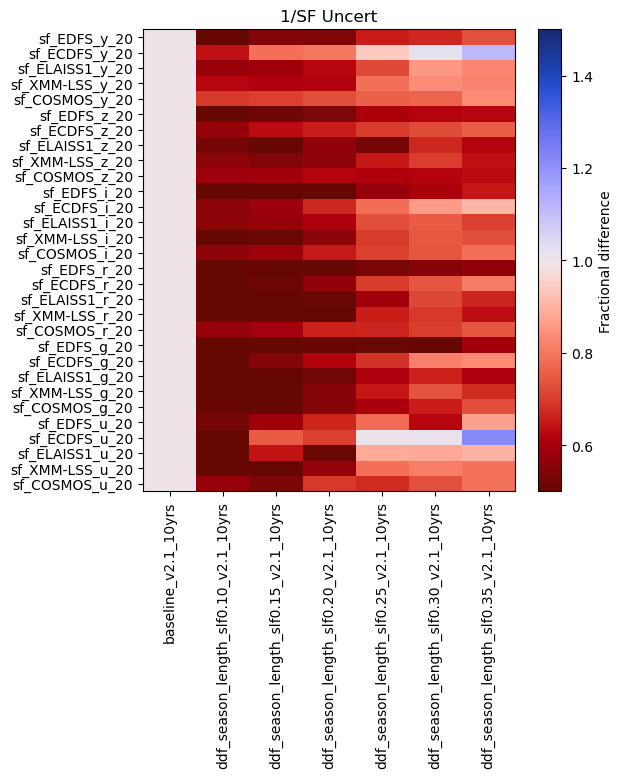

In [97]:
fig, ax = maf.plot_run_metric_mesh(sf_df, baseline_run=baseline_run)
ax.set_title('1/SF Uncert')

#### Median m5

In [108]:
summary_series_ls = []
for mName in m5p50_metricNames:
    summaryVals = getSummary(resultDbs2, mName, 'Median'
                            ).set_index('runName').summaryValue
    summaryVals.name = mName
    summary_series_ls.append(summaryVals)
m5p50_df = pd.concat(summary_series_ls, axis=1)
m5p50_df.index.name = 'run'

Text(0.5, 1.0, 'Median 5-sigma Depth')

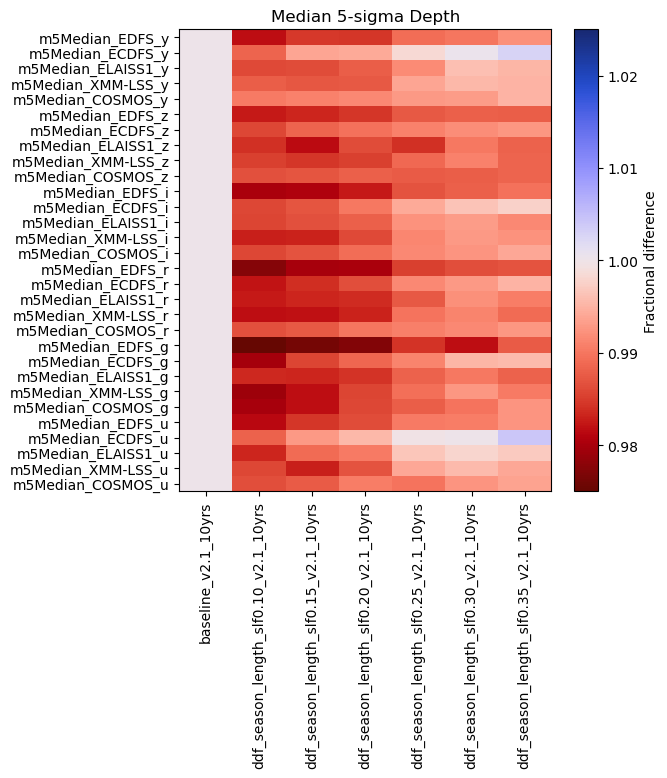

In [109]:
fig, ax = maf.plot_run_metric_mesh(m5p50_df, baseline_run=baseline_run,
                                  color_range=0.05)
ax.set_title('Median 5-sigma Depth')

#### m5 RMS

In [110]:
summary_series_ls = []
for mName in m5rms_metricNames:
    summaryVals = getSummary(resultDbs2, mName, 'Median'
                            ).set_index('runName').summaryValue
    summaryVals.name = mName
    summary_series_ls.append(1/summaryVals)
m5rms_df = pd.concat(summary_series_ls, axis=1)
m5rms_df.index.name = 'run'

Text(0.5, 1.0, '1/RMS 5-sigma Depth')

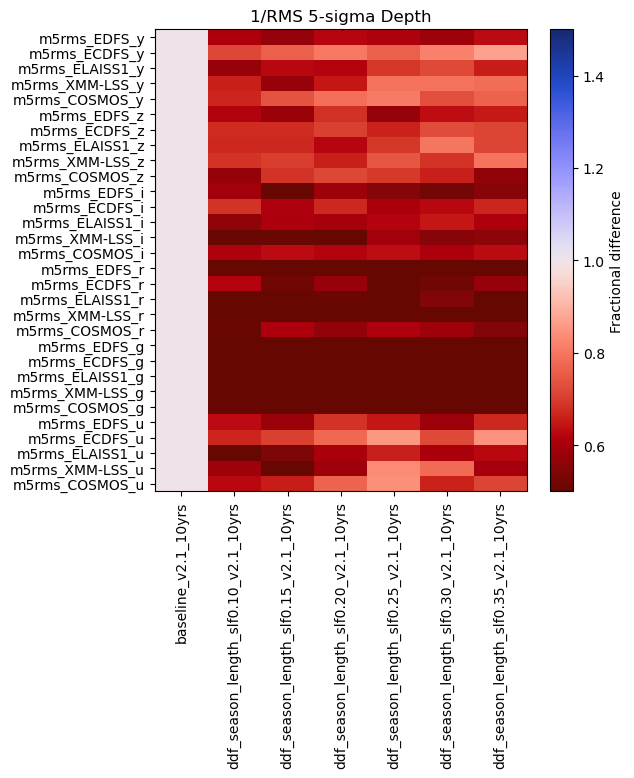

In [111]:
fig, ax = maf.plot_run_metric_mesh(m5rms_df, baseline_run=baseline_run)
ax.set_title('1/RMS 5-sigma Depth')